In [1]:
import os
import xml.etree.ElementTree as ET

'''
    1. 어노테이션 파일을 불러온다.
    2. 데이터의 기본 속성을 파악한다. (데이터 개수, 클래스 개수, 클래스 개수 분포 등)
'''

def xml_parsing(xml_path):
    filename_list = []
    label_list = []
    
    # XML 파일 불러오기
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # 이미지 파일명과 라벨 추출
    for image in root.findall('image'):
        filename = image.find('filename').text
        filename_list.append(filename)
        
        labels = [label.text for label in image.find('labels')]
        label_list.append(labels)
    
    return filename_list, label_list

data_root = '../datasets/chapter03_03'
image_dir = 'images'
annotation_filename = 'annotations.xml'
annotation_path = os.path.join(data_root, annotation_filename)

filename_list, label_list = xml_parsing(annotation_path)
print(filename_list[:2])
print(label_list[:2])

['white_rose_116.jpg', 'white_rose_96.jpg']
[['white', 'rose'], ['white', 'rose']]


In [2]:
from collections import defaultdict
import ast

def get_class_map(label_list):
    cls_map = defaultdict(int)
    for labels in label_list:
        for l in labels: 
            cls_map[l] += 1

    return cls_map

cls_map = get_class_map(label_list)
cls_map

defaultdict(int,
            {'white': 492,
             'rose': 502,
             'yellow': 542,
             'tulip': 532,
             'red': 556,
             'chrysanthemum': 556})

In [3]:
import pandas as pd

'''
    pandas Dataframe으로 어노테이션 테이블 생성
'''

class_list = list(cls_map.keys())
columns = ['filename'] + class_list
annotations = pd.DataFrame(columns=columns)
annotations.head()

/var/folders/x6/kp_dmfr96z17w64bdvy257ym0000gp/T/ipykernel_31896/211556644.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,filename,white,rose,yellow,tulip,red,chrysanthemum


In [4]:
for idx, (filename, labels) in enumerate(zip(filename_list, label_list)):
    row = {}
    row['filename'] = filename
    
    for cls in class_list:
        if cls in labels:
            row[cls] = 1
        else:
            row[cls] = 0
    annotations.loc[idx] = row

In [5]:
annotations = annotations.sample(frac=1).reset_index(drop=True)
annotations.head()

,filename,white,rose,yellow,tulip,red,chrysanthemum
0,white_tulip_90.jpg,1,0,0,1,0,0
1,white_rose_51.jpg,1,1,0,0,0,0
2,yellow_rose_100.jpg,0,1,1,0,0,0
3,yellow_chrysanthemum_45.jpg,0,0,1,0,0,1
4,red_rose_118.jpg,0,1,0,0,1,0


In [6]:
'''
    1. 어노테이션을 랜덤으로 섞는다.
    2. 전체 데이터 샘플을 시각화 한다.
    3. 클래스별 데이터 샘플을 시각화 한다.
    데이터 샘플을 시각화 하여 확인한다.
'''
import matplotlib.pyplot as plt

def draw_images(images, classes):
    '''
        :param images: cv2(ndarray) 이미지 리스트
        :param classes: 클래스 리스트
        :return: None 
    '''
    # 4x2의 그리드 생성 (바둑판 이미지 틀 생성)
    fig, axs = plt.subplots(2, 4)
    
    # 각 하위 그래프에 이미지 출력
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i]) # 이미지를 바둑판에 출력
        ax.set_title(classes[i]) # 클래스 이름으로 이미지 제목 생성 
        # ax.axis('off') # 축 숨기기
    
    plt.tight_layout()
    plt.show()

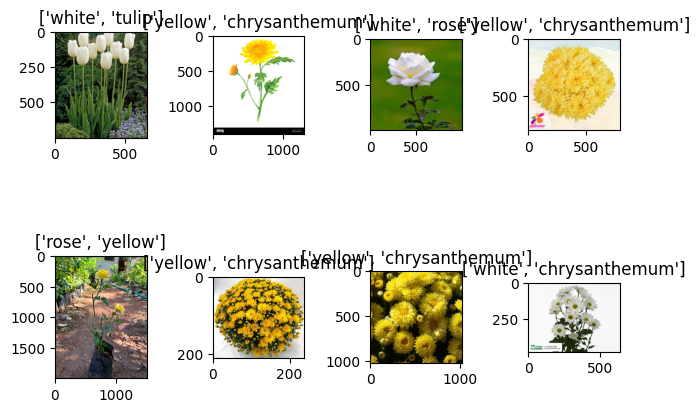

In [7]:
from PIL import Image
import numpy as np
import random

annotations = annotations.sample(frac=1).reset_index(drop=True)
sample_images = [] # 이미지 샘플 저장
sample_classes = [] # 이미지 클래스 저장
sample_cnt = 0 # 시작 count
max_cnt = 8 # 종류 count
for idx, annot in annotations.iterrows():
    classes = []
    for cls in class_list:
        if int(annot[cls]) == 1:
            classes.append(cls)
    sample_classes.append(classes)
    image_path = os.path.join(data_root, image_dir, annot['filename'])
    image = Image.open(image_path).convert('RGB')
    sample_images.append(np.array(image))
    sample_cnt += 1
    if sample_cnt == max_cnt:
        break

## 전체 데이터 샘플을 시각화 한다.
draw_images(sample_images, sample_classes)

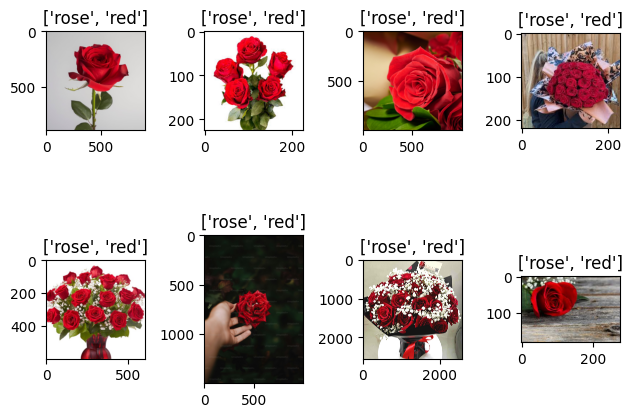

In [8]:
from PIL import Image
import numpy as np
import random

annotations = annotations.sample(frac=1).reset_index(drop=True)
find_cls = ['rose', 'red']
sample_images = [] # 이미지 샘플 저장
sample_classes = [] # 이미지 클래스 저장
sample_cnt = 0 # 시작 count
max_cnt = 8 # 종류 count
for idx, annot in annotations.iterrows():
    classes = []
    for cls in class_list:
        if int(annot[cls]) == 1:
            classes.append(cls)
    if (classes[0] in find_cls) and (classes[1] in find_cls):  
        sample_classes.append(classes)
        image_path = os.path.join(data_root, image_dir, annot['filename'])
        image = Image.open(image_path).convert('RGB')
        sample_images.append(np.array(image))
        sample_cnt += 1
        if sample_cnt == max_cnt:
            break
    else:
        continue

## 전체 데이터 샘플을 시각화 한다.
draw_images(sample_images, sample_classes)

In [9]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

'''
    csv 데이터를 파싱하는 커스텀 데이터세트 클래스를 선언한다.
'''

class CsvDataset(Dataset):
    def __init__(self, 
                 data_root,
                 image_dir,
                 annotations,
                 transform=None):
        '''
            :param data_root: 데이터셋의 루트 경로 
            :param annotations: 어노테이션
            :param transform: 이미지 변환 모듈
        '''
        self.data_root = data_root
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        self.class_list = self._get_classes() # 클래스의 목록
        self.num_classes = len(self.class_list) # 클래스 개수
        
    def __len__(self):
        return len(self.annotations) # 데이터 개수

    def __getitem__(self, idx):
        '''
            :param idx:  
            :return:
                image : 입력 이미지 데이터 (텐서 또는 pillow 이미지)
                target : 정답 클래스 데이터 (원-핫 벡터)
                    예) [1.0, 0.0, 0.0, 1.0, 0.0, ...]
        '''
        annot = self.annotations.iloc[idx]
        image_path = os.path.join(self.data_root, self.image_dir, annot['filename'])
        image = Image.open(image_path).convert("RGB")
        
        target = []
        for cls_num, cls in enumerate(self.class_list):
            if int(annot[cls]) == 1:
                target.append(cls_num)
        target = F.one_hot(torch.tensor(target), self.num_classes).sum(dim=0).to(torch.float)
        
        if self.transform:
            image = self.transform(image)

        return image, target
    
    def _get_classes(self):
        '''
        :return: 클래스의 리스트를 반환한다. 각 인덱스는 클래스 번호가 된다.
            예) ['blue', 'shirts', 'dress', ...] => blue: 0번 클래스, shirts: 1번 클래스, ... 
        '''
        class_list = []
        columns = self.annotations.columns
        for col in columns:
            if col != 'filename':
                class_list.append(col)
        
        class_list.sort()
        return class_list

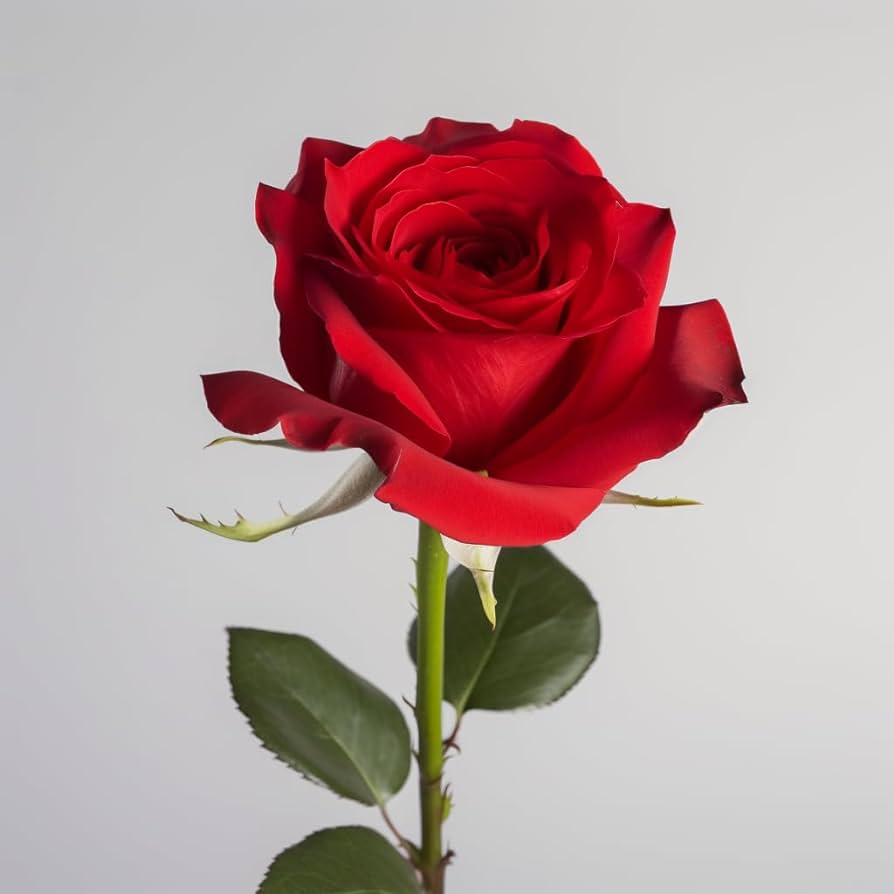

In [10]:
'''
    데이터세트의 출력 값을 시각화 한다.
'''
dataset = CsvDataset(data_root=data_root,
                     image_dir=image_dir,
                     annotations=annotations)
data = dataset[0]
data[0]

In [11]:
print(dataset.class_list)
print(data[1])

['chrysanthemum', 'red', 'rose', 'tulip', 'white', 'yellow']
tensor([0., 1., 1., 0., 0., 0.])


In [12]:
'''
    원본 데이터셋을 학습과 검증셋으로 분할한다.
'''
annotations = annotations.sample(frac=1).reset_index(drop=True)
len_annot = len(annotations)
train_annot = annotations.iloc[ : int(len_annot * 0.9)]
val_annot = annotations.iloc[int(len_annot * 0.9) : ]

print(f'학습 데이터 개수 : {len(train_annot)}')
print(f'검증 데이터 개수 : {len(val_annot)}')

학습 데이터 개수 : 1431
검증 데이터 개수 : 159


In [24]:
'''
    학습에 필요한 하이퍼파라미터를 선언한다.
'''
hyper_params = {
    'num_epochs': 5,
    'lr': 0.001,
    'score_threshold': 0.5, # 모델의 출력값에 대한 임계값
    'image_size': 224,
    'train_batch_size': 4,
    'val_batch_size': 1,
    'print_preq': 0.1 # 학습 중 로그 출력 빈도
}

In [25]:
from torchvision import transforms

'''
    1. 이미지 변환 모듈을 적용한 데이터세트의 결과물을 확인한다.
    2. 학습 및 검증 데이터세트와 데이터로더를 생성한다.
'''
# 샘플 이미지 변환 모듈 설정
sample_transform = transforms.Compose([
    transforms.Resize((hyper_params['image_size'], hyper_params['image_size'])),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ToTensor(), # 테스트 과정에서 사용하지 않음.
])
sample_dataset = CsvDataset(data_root, image_dir, train_annot, sample_transform)


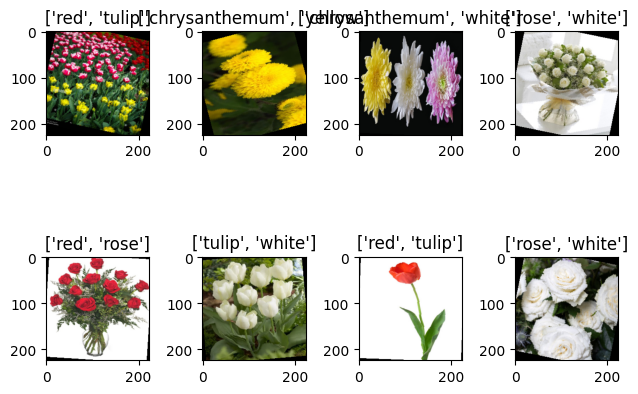

In [26]:
transformed_images = []
targets = []

## 데이터세트에서 변환된 이미지와 target 벡터를 불러온다.
max_cnt = 8
for idx, (image, target) in enumerate(sample_dataset):
    if idx == max_cnt:
        break
    transformed_images.append(image)
    targets.append(target.tolist())

## 타켓 벡터를 클래스로 변환하고 
target_classes = []
class_list = sample_dataset.class_list
for target in targets:
    classes = []
    for cls, val in enumerate(target):
        if int(val) == 1:
            classes.append(class_list[cls])
    target_classes.append(classes)

draw_images(transformed_images, target_classes)

In [27]:
# 학습 및 검증 이미지 변환 모듈 설정
transform = transforms.Compose([
    transforms.Resize((hyper_params['image_size'], hyper_params['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

# 학습 데이터세트 및 데이터로더 설정
train_dataset = CsvDataset(data_root, image_dir, train_annot, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyper_params['train_batch_size'], shuffle=True)

# 검증 데이터세트 및 데이터로더 설정
val_dataset = CsvDataset(data_root, image_dir, train_annot, transform)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyper_params['val_batch_size'], shuffle=False)

In [28]:
import torch
import torch.nn as nn
from torchvision import models

'''
    1. VGG16 모델을 불러온다.
    2. 클래스 개수에 맞게 출력 레이어를 변경한다.
'''

def get_model(num_classes, weight_path=''):
    model = models.vgg16(pretrained=True)
    model.classifier[-1] = nn.Linear(4096, num_classes, bias=True)
    
    if weight_path:
        model.load_state_dict(torch.load(weight_path, map_location='cpu'))
    
    return model

model = get_model(num_classes=train_dataset.num_classes)

/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

'''
    1. loss함수와 옵티마이저를 설정한다.
    2. 학습 루프를 실행한다.
    3. 1 epoch 마다 검증 루프를 실행한다.
'''

# loss 함수와 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = hyper_params['num_epochs']
model_save_dir = './train_results'
os.makedirs(model_save_dir, exist_ok=True)
# 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * hyper_params['print_preq'])

    for idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)
        
        # 순전파
        outputs = model(images)
        loss = criterion(outputs, targets)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        
        if idx % print_cnt == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {running_loss/print_cnt:.4f}")
            running_loss = 0.0
        
        

    # 한 epoch이 끝날 때마다 손실값 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")
    
    # 한 epoch이 끝날 때마다 model weight 저장
    model_save_path = os.path.join(model_save_dir, f'{epoch}_model.pth')
    torch.save(model.state_dict(), model_save_path)

    # F1-score 계산 및 출력
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > hyper_params['score_threshold']).float()  # threshold 설정, 여기서는 0.5로 가정
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='micro')  # F1-score 계산
    print(f"F1-score: {f1:.4f}")

Epoch [1/5], Iter [0/358] Loss: 0.0188


/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5], Iter [35/358] Loss: 0.7384
Epoch [1/5], Iter [70/358] Loss: 0.6510
Epoch [1/5], Iter [105/358] Loss: 0.6506
Epoch [1/5], Iter [140/358] Loss: 0.6416
Epoch [1/5], Iter [175/358] Loss: 0.6407
Epoch [1/5], Iter [210/358] Loss: 0.6449
Epoch [1/5], Iter [245/358] Loss: 0.6502
Epoch [1/5], Iter [280/358] Loss: 0.6401
Epoch [1/5], Iter [315/358] Loss: 0.6374
Epoch [1/5], Iter [350/358] Loss: 0.6418
Epoch [1/5], Loss: 0.6537
F1-score: 0.0000
Epoch [2/5], Iter [0/358] Loss: 0.0163


/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/5], Iter [35/358] Loss: 0.6472
Epoch [2/5], Iter [70/358] Loss: 0.6425
Epoch [2/5], Iter [105/358] Loss: 0.6413
Epoch [2/5], Iter [140/358] Loss: 0.6418
Epoch [2/5], Iter [175/358] Loss: 0.6434
Epoch [2/5], Iter [210/358] Loss: 0.6423
Epoch [2/5], Iter [245/358] Loss: 0.6401
Epoch [2/5], Iter [280/358] Loss: 0.6406
Epoch [2/5], Iter [315/358] Loss: 0.6415
Epoch [2/5], Iter [350/358] Loss: 0.6437
Epoch [2/5], Loss: 0.6422
F1-score: 0.0000
Epoch [3/5], Iter [0/358] Loss: 0.0184
Epoch [3/5], Iter [35/358] Loss: 0.6364


/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/5], Iter [70/358] Loss: 0.6433
Epoch [3/5], Iter [105/358] Loss: 0.6413
Epoch [3/5], Iter [140/358] Loss: 0.6356
Epoch [3/5], Iter [175/358] Loss: 0.6395
Epoch [3/5], Iter [210/358] Loss: 0.6409
Epoch [3/5], Iter [245/358] Loss: 0.6436
Epoch [3/5], Iter [280/358] Loss: 0.6374
Epoch [3/5], Iter [315/358] Loss: 0.6406
Epoch [3/5], Iter [350/358] Loss: 0.6388
Epoch [3/5], Loss: 0.6400
F1-score: 0.0000
Epoch [4/5], Iter [0/358] Loss: 0.0175


KeyboardInterrupt: 